<a href="https://colab.research.google.com/github/Tomawock/NLP_Attack/blob/main/model/ATE_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt


Load Dataset

In [5]:
test = pd.read_json('/content/drive/Shareddrives/Deep Learning/datasets/ATE_ABSITA/ATE_ABSITA_test_set/ate_absita_gold.ndjson'
                       , lines=True)

In [6]:
train = pd.read_json('/content/drive/Shareddrives/Deep Learning/datasets/ATE_ABSITA/ATE_ABSITA_training_set/ate_absita_training.ndjson'
                       , lines=True)

In [7]:
train.head(3)

,sentence,id_sentence,score,polarities,aspects_position,aspects
0,"Ottimo prodotto di marca, la qualità é veramen...",4b7254a1-3f31-4143-ab22-a8558aa4a73b,5,"[[0, 0], [0, 1], [1, 0]]","[[120, 142], [71, 79], [29, 36]]","[provvisto di una tasca, capiente, qualità]"
1,Ottimo rasoio dal semplice utilizzo. Rade molt...,4b74d99d-891f-4526-bbd3-549fa244cd1c,5,"[[1, 0], [1, 0], [1, 0], [1, 0]]","[[18, 26], [37, 41], [79, 86], [99, 105]]","[semplice, Rade, Pratico, pulire]"
2,Un quarto delle dimensioni dello Show original...,4b7ff44f-fa9f-4ef0-97c8-e295e70ccc9b,5,"[[1, 0], [1, 0], [1, 0], [0, 0]]","[[118, 132], [51, 62], [65, 70], [16, 26]]","[modalità notte, prestazioni, suono, dimensioni]"


In [8]:
print(test.columns)
print(train.columns)

Index(['sentence', 'id_sentence', 'score', 'polarities', 'aspects_position',
       'aspects'],
      dtype='object')
Index(['sentence', 'id_sentence', 'score', 'polarities', 'aspects_position',
       'aspects'],
      dtype='object')


In [9]:
train.drop(columns=['id_sentence','polarities','aspects_position','aspects'], inplace=True)
test.drop(columns=['id_sentence','polarities','aspects_position','aspects'], inplace=True)
print(f'Contains {len(train)} sentences')
print(f'Contains {len(test)} sentences')

Contains 3054 sentences
Contains 1200 sentences


In [10]:
train["review_type"] = train["score"].apply(lambda x: "neg" if x < 5 else "pos")
test["review_type"] = test["score"].apply(lambda x: "neg" if x < 5 else "pos")

In [11]:
print(f'TRAIN::\n{train.review_type.value_counts()}')
print(f'COMPLETO::\n{test.review_type.value_counts()}')

TRAIN::
pos    2150
neg     904
Name: review_type, dtype: int64
COMPLETO::
pos    857
neg    343
Name: review_type, dtype: int64


**Necessaria Augemntation**

In [12]:
train.drop(columns=['score'], inplace=True)
test.drop(columns=['score'], inplace=True)

Shuffled datset for improving the learning since negative entries are lower than positive

In [13]:
shuffle=train.sample(frac=1)

In [ ]:
!pip install tensorflow_text

In [14]:
import tensorflow_hub as hub
import numpy as np
import tensorflow_text
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [ ]:
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

changhe shuffle with train if u want to use standard db

In [15]:
from sklearn.preprocessing import OneHotEncoder

one_hot_train = OneHotEncoder(sparse=False).fit_transform(
  shuffle.review_type.to_numpy().reshape(-1, 1)
)

one_hot_test = OneHotEncoder(sparse=False).fit_transform(
  test.review_type.to_numpy().reshape(-1, 1)
)

Trasforma da pos, neg a [0,1], [1,0]

In [16]:
one_hot_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [17]:
shuffle.review_type

393     neg
293     pos
2793    neg
2846    pos
1044    pos
       ... 
1492    pos
973     pos
2469    pos
2791    pos
301     neg
Name: review_type, Length: 3054, dtype: object

In [ ]:
one_hot_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
test.review_type

0       neg
1       neg
2       neg
3       pos
4       pos
       ... 
1195    pos
1196    pos
1197    pos
1198    pos
1199    pos
Name: review_type, Length: 1200, dtype: object

In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [39]:
from nltk.tokenize import word_tokenize


train.tokens = word_tokenize(train.sentence[:])

TypeError: ignored

How to find batch size, if it not belongs to N, the code will not work (we know why but is not crystal clear)

In [ ]:
# define the LSTM model
model = Sequential()
model.add(keras.layers.Input(shape=(1,), dtype=tf.string))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
model.summary()

In [ ]:
# define the checkpoint
from tensorflow.keras.callbacks import History 
history = History()
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,history]
# fit the model
result=model.fit(shuffle['sentence'], type_one_hot, epochs=10, batch_size=6, callbacks=callbacks_list)

In [ ]:
result.history

{'accuracy': [0.7039947509765625,
  0.7039947509765625,
  0.7039947509765625,
  0.7039947509765625,
  0.7039947509765625,
  0.7039947509765625,
  0.7039947509765625,
  0.7039947509765625,
  0.7039947509765625,
  0.7039947509765625],
 'loss': [0.6097841262817383,
  0.6106885671615601,
  0.6090911030769348,
  0.6110088229179382,
  0.6087533831596375,
  0.6101961135864258,
  0.6103624701499939,
  0.609462559223175,
  0.6088404655456543,
  0.6094622015953064]}

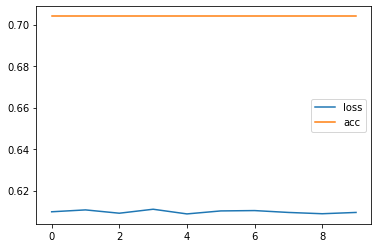

In [ ]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['accuracy'], label='acc')
plt.legend()
plt.show()